**PRÁCTICA**: implementar una GAN que genere parejas de números que cumplan (x, x^2).

**NOTA**: escoger TPU.

# Mi primera GAN

En este Notebook vamos a implementar nuestra primera GAN. Recordad la arquitectura:

<center><img src="https://miro.medium.com/max/2426/1*XKanAdkjQbg1eDDMF2-4ow.png"></center>

Como ya hemos visto, una GAN consta de un generador (*el falsificador)* y un discriminador (*el policía*).

Vamos a comenzar con un ejemplo muy sencillo que iremos complicando conforme avancemos. En esta ocasión no vamos a crear dinero, sino que vamos a generar nuevas muestras que encajen en la función $x^2$. Las muestras reales (nuestro dataset) son las que véis dibujadas en la gráfica siguiente:

<center><img src="http://mathcentral.uregina.ca/QQ/database/QQ.09.06/mike1.1.gif"></center>

Así que lo primero que vamos a hacer es crear una función que nos permita generar dichas muestras:

In [1]:
# importamos lo que vamos a necesitar
import numpy as np
from numpy.random import rand, randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# generamos muestras reales con sus correspondientes etiquetas (1)
def generate_real_samples(n):
    # vamos a generar datos entre -0.5 y 0.5
    X1 = rand(n) - 0.5
    # nuestros datos son x^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    # generate class labels
    y = np.ones((n, 1))
    return X, y

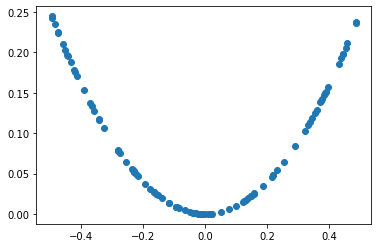

In [3]:
# generamos nuestro dataset
X, y = generate_real_samples(n=100)
# plot samples
plt.scatter(X[:, 0], X[:, 1])
plt.show()


Nuestra meta en este caso es ser capaces de generar nuevas parejas de datos $(x, x^2)$ lo más similares posibles a los que generaría la función $f(x)=x^2, x \in [-0.5, 0.5]$.

Vamos a crear primero nuestro discriminador. Lo primero es pensar cuales van a ser las entradas y cuales las salidas. Veamos:

Las entradas serán parejas $(x, x^2)$ entre -0.5 y 0.5. Por ejemplo: $(0.2, 0.04)$, $(0.4, 0.16)$, $(-0.2, 0.04)$, $(-0.4, -0.16)$, etc.

La salida será un valor binario: 1 si la pareja $(x, x^2)$ realmente se parece a la función $f(x)=x^2$, 0 en caso contrario.

Vamos a definirlo:

In [4]:
# definimos el discriminador
def define_discriminator(n_inputs=2):
    model = Sequential()
    # Nuestro discriminador va a ser muy sencillo: va a tener 2 capas densas.
    # la primera, tendrá 25 neuronas, activación relu e inicialización 'he_uniform' (https://keras.io/initializers/)
    # además, tendremos que indicarle las dimensiones de entrada (con el atributo input_dim)
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    # la segunda, será una densa de 1 única neurona y activación sigmoide: 
    # queremos que nos de la probabilidad de que la imagen sea real
    model.add(Dense(1, activation='sigmoid'))
    # utilizamos función de activación final sigmoide y la cross entropía
    # binaria para que la red nos devuelva las probabilidades de que la entrada
    # sea falsa y real
    # el optimizador que usaremos en este caso es el adam con los parámetros por defecto
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Perfecto, ya lo tenemos.

Ahora necesitamos el generador. ¿Qué es lo que necesitamos que haga el generador? Que genere 2 números que vamos a intentar aproximar a $(x, x^2)$ mediante entrenamiento.

Vamos a ello:

In [5]:
# definimos el generador
def define_generator(latent_dim, n_outputs=2):
    # fijaos en varios detalles:
    # - latent_dim: es el tamaño del vector de ruido de la entrada. 
    # Cuanto mayor sea, más complejos serán los datos que podremos generar
    # - la función de activación final ha de ser lineal: esto es muy importante, 
    # ya que estamos haciendo un trabajo de regresión (estamos tratando de
    # llegar a $(x, x^2)$ desde el valor introducido a la red (el vector latente)
    # - no compilamos el modelo: esto se debe a que durante el entrenamiento 
    # del G(z) vamos a necesitar acoplar G(z) a D(x)

    # vamos a definir un modelo haciendo uso del modelo Sequential de keras
    model = Sequential()
    # le añadiremos una capa densa de 15 neuronas, con activación relu e
    # inicialización de pesos 'he_uniform', y tendremos que indicarle las 
    # dimensiones de entrada, igual que en el caso del discriminador
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) 
    # la última capa tendrá tantas neuronas como números esperamos generar
    # (en este caso x y x^2) y activación lineal
    model.add(Dense(n_outputs, activation='linear'))
    return model

Generador definido. Ahora vamos a combinar el generador y el discriminador para crear el modelo Generativo Adversarial:

In [6]:
# definimos el modelo GAN combinando generador y discriminador, para entrenar el generador
def define_gan(generator, discriminator):
    # recordad que durante el entrenamiento del generador necesitamos al
    # discriminador para que nos diga si la muestra es real o no, pero
    # no debemos actualizar los pesos del discriminador, ya que si no,
    # estaríamos haciendo trampas: estaríamos haciendo peor al D(x)
    # Así que congelamos el discriminador:
    discriminator.trainable = False
    # ahora conectamos el G(z) al D(x)
    model = Sequential()
    # añadimos el generador primero: él es el encargado de generar una muestra
    # a partir del espacio latente
    model.add(generator)
    # y el discriminador después: le introducimos la muestra generada por el 
    # G(z) para que nos diga si cree que es real o fake
    model.add(discriminator)
    # y ahora sí, compilamos el modelo con optimizador adam y función de
    # pérdidas binary crossentropy
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Bueno, ya lo tenemos todo, ¿no?

Pues casi, pero no: nos faltan un par de funciones, una que nos devuelva el vector latente que introducirle al G(z) y otra que coja ese vector latente y produzca una muestra fake. 

Fijaos lo sencillo que es:

In [7]:
# generamos los vectores latentes que introduciremos al generador
def generate_latent_points(latent_dim, batch_size):
    # generamos un vector de batch_size * latent_dim números aleatorios
    # latent_dim es la dimensión del vector latente
    # batch_size es el número de elementos por batch
    x_input = randn(latent_dim * batch_size)
    # redimensionamos el vector para que tenga un tamaño (batch_size, latent_dim)
    x_input = x_input.reshape(batch_size, latent_dim)
    return x_input

# creamos datos fake con el generador (dinero falsificado)
def generate_fake_samples(generator, latent_dim, n): 
    # usamos la función anterior para generar los vectores latentes que 
    # necesitamos para generar muestras fake
    # queremos generar 'n' códigos latentes de 'latent_dim'
    x_input = generate_latent_points(latent_dim, n)
    # le introducimos los vectores latentes al generador para obtener
    # muestras similares a las reales
    X = generator.predict(x_input)
    # le asignamos la etiqueta 0 (porque son falsas)
    y = np.zeros((n, 1)) 
    return X, y

¡Ahora sí! Ya solo nos falta implementar el bucle de entrenamiento. Vamos a ello:

In [8]:
# función para entrenar la GAN: el discriminador y el generador
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # para entrenar el discriminador, le introduciremos la mitad de los datos
    # reales y la otra mitad falsa
    half_batch = int(n_batch / 2)
    for epoch in tqdm(range(n_epochs)):
        
        # preparamos los datos reales (generados con f(x)=x^2)
        x_real, y_real = generate_real_samples(half_batch)
        
        # preparamos los datos falsos (creados con el generador)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        # entrenamos el discriminador
        d_model.train_on_batch(x_real, y_real) # primero con los datos reales
        d_model.train_on_batch(x_fake, y_fake) # luego con los datos fake
        
        # preparamos los puntos en el espacio latente: serán la entrada al
        # modelo GAN con el que entrenaremos el generador
        x_gan = generate_latent_points(latent_dim, n_batch)
        
        # creamos etiquetas invertidas para el generador: utilizamos el D(x) 
        # para que piense que las muestras que le introducimos son reales, y
        # en caso de que diga que no son reales, aprovechamos la información
        # de sus gradientes para actualizar el G(z) para que la próxima vez
        # los datos generados por G(z) sean más plausibles (parecidos a los 
        # reales)
        y_gan = np.ones((n_batch, 1))
        
        # como acabamos de ver, entrenamos el generador de forma que actualice
        # sus pesos usando los gradientes del discriminador
        # tened en cuenta que en este modelo (gan_model) el discriminador está
        # congelado, por lo que no se actualizan sus pesos: no queremos "untar"
        # a nuestro policía, lo que queremos es fabricar dinero más realista.
        gan_model.train_on_batch(x_gan, y_gan)

        # evaluamos el modelo cada n_eval épocas
        if (epoch+1) % n_eval == 0 or epoch == 0:
            # preparamos ejemplos reales
            x_real, y_real = generate_real_samples(n_batch)
            # evaluamos el discriminador con datos reales
            _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
            # preparamos ejemplos fake
            x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_batch)
            # evaluamos el discriminador con datos fake
            _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
            # mostramos cómo de bueno es nuestro policía
            print(epoch, acc_real, acc_fake)
            # lo ploteamos
            plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
            plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue') 
            # lo guardamos para tenerlo disponible más tarde
            filename = 'generated_plot_e%03d.png' % (epoch+1) 
            plt.savefig(filename)
            plt.close()

In [9]:
# comenzamos con el entrenamiento

# tamaño del espacio latente
latent_dim = 5
# creamos el discriminador
discriminator = define_discriminator()
# creamos el generador
generator = define_generator(latent_dim)
# creamos la GAN
gan_model = define_gan(generator, discriminator)
# entrenamos!
train(generator, discriminator, gan_model, latent_dim)

  0%|                                                                              | 3/10000 [00:01<1:27:49,  1.90it/s]

0 0.046875 1.0


 20%|███████████████▍                                                             | 2000/10000 [01:53<27:54,  4.78it/s]

1999 0.4609375 0.546875


 40%|██████████████████████████████▊                                              | 4002/10000 [04:22<07:38, 13.09it/s]

3999 0.7109375 0.3828125


 60%|██████████████████████████████████████████████▏                              | 6002/10000 [06:12<04:47, 13.92it/s]

5999 0.4765625 0.59375


 80%|█████████████████████████████████████████████████████████████▌               | 8000/10000 [07:58<02:40, 12.47it/s]

7999 0.703125 0.484375


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:45<00:00, 17.09it/s]

9999 0.484375 0.625


Vamos a ver cómo ha ido el entrenamiento de nuestra red. Para ello, vamos a visualizar la salida del generador al principio, cuando aún no estaba entrenada, y al final, cuando ya estaba entrenada.

In [10]:
ls -lah

 El volumen de la unidad D es Datos
 El n£mero de serie del volumen es: 400A-7D99

 Directorio de D:\Master\edemMDA\GAN



No se encuentra el archivo


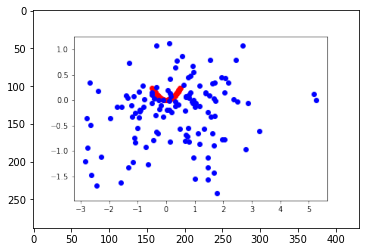

In [11]:
plt.imshow(plt.imread('generated_plot_e001.png'))
plt.show()

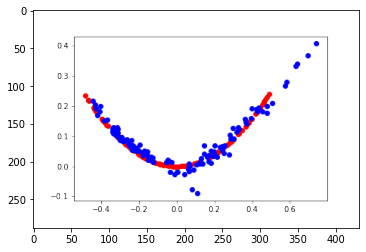

In [12]:
plt.imshow(plt.imread('generated_plot_e2000.png'))
plt.show()

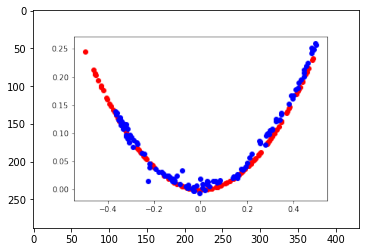

In [13]:
plt.imshow(plt.imread('generated_plot_e10000.png'))
plt.show()

¡Fijáos! El generador ha aprendido a generar datos practicamente iguales a los de nuestro dataset original. ¿Os dáis cuenta de la potencia de esto? Y este es el ejemplo más sencillo que he podido poner.